In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

In [2]:
PAD = -1
def build_vocab(file):
    all_words = []
    all_labels = []
    with open(file, "r") as handle:
        lines = handle.readlines()
        for l in lines:
            l = l.split()
            if len(l):
                if len(l) > 2:
                    print("Weird line here..")
                    continue
                all_words.append(l[0])
                all_labels.append(l[1])   
            
    all_words = list(set(all_words))                    
    all_labels = list(set(all_labels)) 
    vocab = dict(zip(all_words, [i for i in range(len(all_words))]))
    labels = dict(zip(all_labels, [i for i in range(len(all_labels))]))    
    l = len(vocab)
    vocab['UNK'] = l
    vocab['PAD'] = l + 1
    global PAD
    PAD = vocab['PAD']
    return vocab, labels

def get_data_examples(fname, vocab_dict, labels_dict):
    sentences = []
    labels = []

    sentence = []
    label = []

    with open(fname) as handle:
        for l in handle.readlines():
            l = l.split()
            if len(l)==0 and len(sentence):
                assert len(sentence) == len(label)
                sentences.append(np.array(sentence))
                labels.append(np.array(label))
                sentence = []
                label = []
            else:
                try:
                    sentence.append(vocab_dict[l[0]])
                except:
                    sentence.append(vocab_dict["UNK"])
                label.append(labels_dict[l[1]])
                    
    assert len(sentences) == len(labels) 
    return sentences, labels

In [3]:
class NerDataset(Dataset):
    def __init__(self, fname, vocab_dict=None, labels_dict=None):
        if vocab_dict is None:
            self.vocab_dict, self.labels_dict = build_vocab(fname)
        else:
            assert labels_dict is not None, "weird.. why would you do this?"
            self.vocab_dict, self.labels_dict = vocab_dict, labels_dict
        self.sentences, self.labels = get_data_examples(fname, self.vocab_dict, self.labels_dict)
        
    def __getitem__(self, idx):
        s = torch.LongTensor(self.sentences[idx])
        l = torch.LongTensor(self.labels[idx])
        return s, l
    
    def __len__(self):
        return len(self.sentences)
    
def pad_collate(batch):
    """For equal length sequences. Source [1]
    [1]: https://suzyahyah.github.io/pytorch/2019/07/01/DataLoader-Pad-Pack-Sequence.html"""
    xx, yy = zip(*batch)
    x_lens = [len(x) for x in xx]
    y_lens = [len(y) for y in yy]
    
    
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=PAD)
    yy_pad = pad_sequence(yy, batch_first=True, padding_value=-1)
    
    return xx_pad, yy_pad, x_lens, y_lens    

In [4]:
# train_f = "../data/NCBI-disease/train.tsv"
# dev_f = "../data/NCBI-disease/devel.tsv"

train_f = "../data/train_all.tsv"
dev_f = "../data/devel_all.tsv"

shuffle = True
bs = 64
train_dataset = NerDataset(train_f)
val_dataset = NerDataset(dev_f, train_dataset.vocab_dict, train_dataset.labels_dict)

train_loader = DataLoader(dataset=train_dataset, batch_size=bs, shuffle=shuffle, collate_fn=pad_collate)
val_loader = DataLoader(dataset=val_dataset, batch_size=bs, shuffle=shuffle, collate_fn=pad_collate)

for s, l, x_len, y_len in train_loader: #a small unit test
    print(s.shape)
    print(l.shape)
    break
    
print(len(train_loader))    
print(len(val_loader))    

torch.Size([64, 61])
torch.Size([64, 61])
1409
813


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self,
                vocab_size,
                embedding_dim,
                lstm_hidden_dim,
                number_of_tags,
                n_stack=2,
                dropout=0.2,
                bidirectional=True):
        super(Net, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, 
                            lstm_hidden_dim, 
                            batch_first=True,
                            num_layers=n_stack,
                            dropout=dropout,
                            bidirectional=bidirectional)
        if bidirectional: lstm_hidden_dim *= 2
        self.fc = nn.Linear(lstm_hidden_dim, number_of_tags)

    def forward(self, s):
        s = self.embedding(s)   
        s, _ = self.lstm(s)           
        s = s.reshape(-1, s.shape[2])
        s = self.fc(s)
        return F.log_softmax(s, dim=1)   

In [7]:
def loss_fn(outputs, labels):
    labels = labels.flatten()
    mask = (labels >= 0)
    return F.nll_loss(outputs[mask], labels[mask])

In [18]:
embedding_dim = 64
lstm_hidden_dim = 16
n_stack = 2
dropout = 0.6
bidirectional = True
vocab_size = len(train_dataset.vocab_dict) + 1
number_of_tags = len(train_dataset.labels_dict)
device = "cuda"
lr = 3e-2
# lr = 0.1
momentum = 0.99
n_epochs = 10

model = Net(vocab_size,
            embedding_dim,
            lstm_hidden_dim,
            number_of_tags,
            n_stack,
            dropout,
            bidirectional).to(device)

optimizer = torch.optim.SGD(model.parameters(), 
                            lr=lr,
                            momentum=momentum)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
crit = loss_fn

In [19]:
from tqdm.notebook import tqdm

def acc(ypreds, ytrue):
    mask = (ytrue >= 0)
    ypreds = ypreds[mask]
    ytrue = ytrue[mask]
    return (ypreds==ytrue).sum()/len(ytrue)

In [20]:
from collections import defaultdict
metrics = defaultdict(list)


for epoch in tqdm(range(n_epochs)):
    running_train_loss = 0
    running_val_loss = 0
    running_train_acc = 0
    running_val_acc = 0
    model.train()
    for i, data in enumerate(train_loader):
        X, y, _, _ = data
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = crit(output, y.flatten())
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            running_train_loss += loss.item()
            ypreds = output.argmax(axis=1).detach().cpu().numpy()
            ytrue = y.flatten().detach().cpu().numpy()
            running_train_acc += acc(ypreds, ytrue)
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y, _, _ = data
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = crit(output, y.flatten())
            running_val_loss += loss.item()   
            ypreds = output.argmax(axis=1).detach().cpu().numpy()
            ytrue = y.flatten().detach().cpu().numpy()
            running_val_acc += acc(ypreds, ytrue)
            
    print(f"Epoch: [{epoch}/{n_epochs}] |" +
            f"Train Loss: {running_train_loss/len(train_loader):.3f} | " +
            f"Train Acc: {running_train_acc/len(train_loader):.3f} | " +
            f"Val Loss: {running_val_loss/len(val_loader):.3f} | " +
            f"Val Acc: {running_val_acc/len(val_loader):.3f}"
            )    
    
    metrics['train_loss'].append(running_train_loss/len(train_loader))
    metrics['train_acc'].append(running_train_acc/len(train_loader))    
    metrics['val_loss'].append(running_val_loss/len(val_loader))    
    metrics['val_acc'].append(running_val_acc/len(val_loader))    

Epoch: [0/10] |Train Loss: 0.177 | Train Acc: 0.933 | Val Loss: 0.153 | Val Acc: 0.941
Epoch: [1/10] |Train Loss: 0.135 | Train Acc: 0.948 | Val Loss: 0.152 | Val Acc: 0.940
Epoch: [2/10] |Train Loss: 0.129 | Train Acc: 0.950 | Val Loss: 0.157 | Val Acc: 0.936
Epoch: [3/10] |Train Loss: 0.125 | Train Acc: 0.951 | Val Loss: 0.165 | Val Acc: 0.933
Epoch: [4/10] |Train Loss: 0.124 | Train Acc: 0.952 | Val Loss: 0.156 | Val Acc: 0.938
Epoch: [5/10] |Train Loss: 0.124 | Train Acc: 0.952 | Val Loss: 0.168 | Val Acc: 0.928
Epoch: [6/10] |Train Loss: 0.123 | Train Acc: 0.952 | Val Loss: 0.160 | Val Acc: 0.937
Epoch: [7/10] |Train Loss: 0.122 | Train Acc: 0.953 | Val Loss: 0.165 | Val Acc: 0.934
Epoch: [8/10] |Train Loss: 0.121 | Train Acc: 0.953 | Val Loss: 0.157 | Val Acc: 0.937
Epoch: [9/10] |Train Loss: 0.121 | Train Acc: 0.953 | Val Loss: 0.188 | Val Acc: 0.926



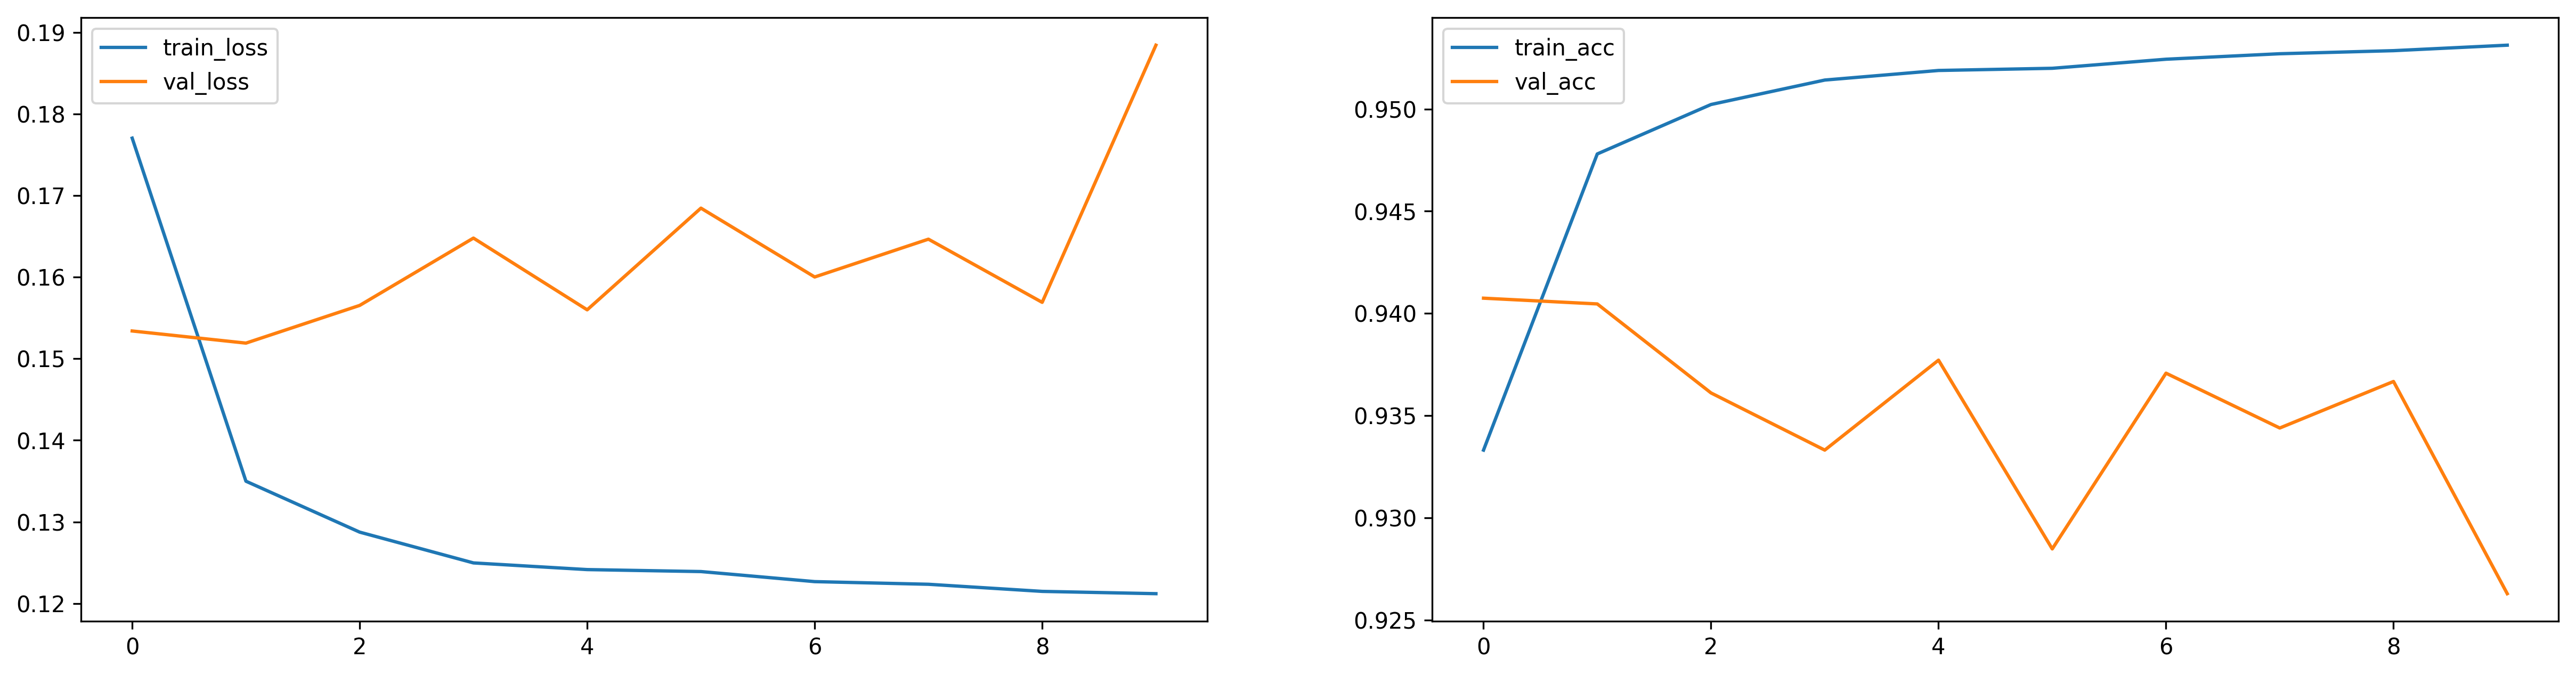

In [23]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), dpi=300)
ax1.plot(metrics['train_loss'])
ax1.plot(metrics['val_loss'])
ax1.legend(['train_loss', 'val_loss'])

ax2.plot(metrics['train_acc'])
ax2.plot(metrics['val_acc'])
ax2.legend(['train_acc', 'val_acc'])


plt.show()

In [22]:
def infer(sentence, model, vocab_dict, labels_dict):
    s = [vocab_dict[w] if w in vocab_dict else vocab_dict["UNK"] for w in sentence.split()]
    model_inp = torch.LongTensor(s).view(1, -1).to(device) #bs of 1
    model.eval()
    with torch.no_grad():
        y = model(model_inp).detach().cpu().numpy()
    preds = y.argmax(axis=1)
    mask = (preds!=labels_dict['O'])
    return np.array(sentence.split())[mask]

In [35]:
vocab_dict = train_dataset.vocab_dict
labels_dict = train_dataset.labels_dict

sentence = "Optum is trying the best to fight endometrial and colorectal cancer."
preds = infer(sentence, model, vocab_dict, labels_dict)
print(preds)

['Optum' 'colorectal' 'cancer.']


In [33]:
sentence = "She is suffering from skin cancer."
preds = infer(sentence, model, vocab_dict, labels_dict)
print(preds)

['cancer.']


In [44]:
sentence = "She is suffering from Angelman syndrome and colorectal, endometrial cancer."
preds = infer(sentence, model, vocab_dict, labels_dict)
print(preds)

['Angelman' 'syndrome' 'colorectal,' 'endometrial' 'cancer.']


In [37]:
torch.save(model.state_dict(), "temp.pth")

In [39]:
model.load_state_dict(torch.load("temp.pth"))

<All keys matched successfully>